## Advect Sea-Ice

This notebook advects sea-ice using the low resolution sea ice drift product of the EUMETSAT Ocean and Sea Ice Satellite Application Facility (OSI SAF, https://osi-saf.eumetsat.int). Adapted and built upon from code shared by Michel Tsamados, adapted from earlier code by Thomas Rackow.


Heather Tweedie  
May 2024  
MSci Dissertation

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
import xarray as xr
import pandas as pd
from scipy import spatial
from datetime import datetime
from datetime import timedelta
import os.path
import h5py as h5
from scipy.spatial import KDTree
import pyproj
from geopy.distance import geodesic


Set the `YEAR` to forward. Advection will start from `START_DATE` (currently 1st April of the year specified).  
Set the `SPACING`, i.e. the spacing of points in the grid to be forwarded. `SPACING=100` will forward every 100th grid point. Set `SPACING=1` to forward every grid point.  
Set the number of `DAYS_TO_FORWARD`. Set `DAYS_TO_FORWARD=153` for 1st April to 31st August, or `DAYS_TO_FORWARD=183` for 1st April to 30th September.

In [35]:
YEAR = 2020
START_DATE = f'{YEAR}-04-01 12:00:00'
SPACING = 150
DAYS_TO_FORWARD = 153


### Loac class and functions

In [36]:
class Buoys:
    
    global rad, r_earth
    rad=np.pi/180.0 # radiant <-> degree
    r_earth=6.3675*10**6 # radius of Earth in [m]
    
    def __init__(self, lon_start, lat_start, earliest_date_of_buoy, start_advect_date):
        print(lon_start)
        self.oldlon = lon_start * rad
        self.oldlat = lat_start * rad
        self.lon = lon_start * rad
        self.lat = lat_start * rad
        self.initlon = lon_start * rad
        self.initlat = lat_start * rad
        self.old_u = np.zeros(lon_start.shape)
        self.old_v = np.zeros(lon_start.shape)
        self.date = datetime.strptime(earliest_date_of_buoy, "%Y-%m-%d %H:%M:%S")
        self.startdates = start_advect_date
        #self.delta_x = np.zeros(lon_start.shape)
        #self.delta_y = np.zeros(lon_start.shape)
        #self.u_ice = np.zeros(lon_start.shape)
        #self.v_ice = np.zeros(lon_start.shape)
        
    def getdate(self):
        return self.date.strftime("%Y-%m-%d %H:%M:%S")
        
    def trajectory(self, new_u, new_v, delta_t):
        print("Update buoy positions. Integrate for " + str(delta_t/3600.) + " hours.")
        
        #save old position in case the drifter leaves the domain
        self.oldlon = self.lon # radiant
        self.oldlat = self.lat # radiant
        
        #displacement vectors
        deltax1 = self.old_u * delta_t
        deltay1 = self.old_v * delta_t
        deltax2 = new_u * delta_t
        deltay2 = new_v * delta_t
        
        #Heun method (2nd order)
        self.lon = self.lon + (0.5*(deltax1 + deltax2) / (r_earth*np.cos(self.lat.values)) )
        self.lat = self.lat + (0.5*(deltay1 + deltay2) /  r_earth )
        
        # keep degree in range 0..360 and -90..90
        lon_deg = self.lon/rad % 360
        lat_deg = np.clip(self.lat/rad, -90., 90.)
        self.lon = lon_deg*rad
        self.lat = lat_deg*rad
        
        #update velocity here (old value was needed for heun method)
        self.old_u=new_u
        self.old_v=new_v
        
        # set positions to NaN before the buoy is supposed to move
        #idx=getindices_beforestart(self.getdate(), self.startdates)
        #lon_deg[idx] = np.nan
        #lat_deg[idx] = np.nan
        #self.lon[idx] = self.initlon[idx]
        #self.lat[idx] = self.initlat[idx]
        #self.old_u[idx]=0.
        #self.old_v[idx]=0.
        
        # update time stamp
        self.date = self.date + timedelta(seconds=delta_t)

        return lon_deg, lat_deg


In [37]:
def length_of_latitude_circle(lat=85.):
    r_earth=6.3675*10**6 # radius of Earth in [m]
    rad=np.pi/180.0 # radiant <-> degree
    return 2*np.pi*r_earth*np.cos(lat*rad) / 1000. # km


# find the buoys that are not to be advected yet (current date < start date)
def getindices_beforestart(currentdate, startdates):
        
    indices=np.zeros(np.shape(startdates),dtype='bool')
    for i,val in enumerate(startdates):
        # don't advect yet
        if currentdate < startdates[i]:
            indices[i]=True
            
    return indices


# load OSISAF data for Northern Hemisphere at a certain date
def loaddate_ofOSISAF(datestring, hemisphere='nh'):
    
    # convert datestring to datetime object
    thedate = datetime.strptime(datestring, "%Y-%m-%d %H:%M:%S")
    
    # let's construct the file name, 
    # e.g. drift-velocities/archive/ice/drift_lr/merged/2019/09/
    # ice_drift_nh_polstere-625_multi-oi_201909011200-201909031200.nc
    pathtofile = "/home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/"
    # middle part
    middlefilename="ice_drift_"+hemisphere+"_polstere-625_multi-oi_"
    # e.g. 201907291200-201907311200 (48hr span)
    enddate=thedate + timedelta(days=2)
    # YYYY/MM/ (from end date)
    YYYYMM=enddate.strftime("%Y")+"/"+enddate.strftime("%m")+"/"
    endfilename= thedate.strftime("%Y%m%d%H%M") + "-" + enddate.strftime("%Y%m%d%H%M") + '.nc'
    
    # the OSISAF file to be loaded
    filename=pathtofile + YYYYMM + middlefilename + endfilename
    
    # take previous files in case there is a data gap
    sd=thedate
    ed=enddate
    while os.path.isfile(filename)!=True:
        # try previous file
        sd=sd - timedelta(days=1)
        ed=ed - timedelta(days=1)
        # YYYY/MM/ (from end date)
        YYYYMM=ed.strftime("%Y")+"/"+ed.strftime("%m")+"/"
        endfilename= sd.strftime("%Y%m%d%H%M") + "-" + ed.strftime("%Y%m%d%H%M") + '.nc'
        filename=pathtofile + YYYYMM + middlefilename + endfilename
        print('data gap: try previous file '+filename+' ...')
    
    print("loading "+filename+ " ...") # Python3 needs brackets here
    
    # load the file
    fl = Dataset(filename)
    #xc=fl.variables['xc']
    #yc=fl.variables['yc']
    #XC,YC=np.meshgrid(xc,yc)
    
    # lon lat on grid
    lon_start=np.copy(fl.variables['lon'])
    lat_start=np.copy(fl.variables['lat'])

    # lon lat at the end of the displacement
    lon_end=np.squeeze(fl.variables['lon1'][0,:,:])
    lat_end=np.squeeze(fl.variables['lat1'][0,:,:])
    
    # close the file
    fl.close()
    
    # compute Ufield from end points and start points (48hour change)
    deltalon=lon_end-lon_start
    deltalon[deltalon>100.]=deltalon[deltalon>100.]-360.   # jump at -180..180
    deltalon[deltalon<-100.]=deltalon[deltalon<-100.]+360. # jump at -180..180
    Ufield=deltalon/48. *length_of_latitude_circle(lat=lat_start[:,:])/360. / 3.6 # km/h -> m/s
    
    # compute Vfield as well
    Vfield=(lat_end-lat_start)/48. *length_of_latitude_circle(lat=0.)/360. / 3.6 #km/h -> m/s
    
    return Ufield, Vfield, lon_start, lat_start


# nearest-neighbor interpolation, finds U,V at the position of the buoys using a fast KDTree method
def find_UV_atbuoy_pos(lon_start,lat_start, Ufield,Vfield, objects):
    
    # (lon,lat) tuples of the underlying grid
    A = np.array([lon_start[:,:].flatten(), lat_start[:,:].flatten()]).T # -180..180 assumed in OSISAF
    # change to -180..180 as assumed in OSISAF data; in the trajectory code its 0..360
    lon_adjust = objects.lon/rad
    lon_adjust[lon_adjust>180.] = lon_adjust[lon_adjust>180.]-360.
    # zip buoy (lon & lat) arrays to (lon,lat) tuples
    tuples = np.column_stack((lon_adjust, objects.lat/rad)) 
    # fast KDTree nearest neighbor method
    idx = spatial.KDTree(A).query(tuples)[1]
    
    return Ufield[idx], Vfield[idx]


def WGS84toEASE2N(lon, lat):
    '''Converts WGS84 coordinates to EASE2N.

    Params:
        lon (array): the WGS84 longitude to convert
        lat (array): the WGS84 latitude to convert

    Returns:
        (x, y): the corresponding EASE2N x and y coordinates
    '''

    proj_EASE2N = pyproj.Proj("+proj=laea +lon_0=0 +lat_0=90 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")
    proj_WGS84 = pyproj.Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs ")
    return pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


def load_MISR(MISR_path):
    '''Loads MISR data and coordinates from specified file path.

    Params:
        MISR_path (str): the file path from which to retrieve data

    Returns:
        data (np.array): roughness data retrieved from the specified file
        lon, lat
        x, y
    '''

    file = h5.File(MISR_path, 'r')
    
    # extract coord data
    lon = np.array(file['GeoLocation']['Longitude'])
    lat = np.array(file['GeoLocation']['Latitude'])
    x = np.array(file['GeoLocation']['x'])
    y = np.array(file['GeoLocation']['y'])

    # extract roughness data
    data = np.array(file['Roughness']['Roughness_2D_svm'])    
    
    file.close()

    return data, lon, lat, x, y



### Inspect ice drift data files

Inspect and plot example file:

In [38]:
! ncdump -h /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2019/09/ice_drift_nh_polstere-625_multi-oi_201909041200-201909061200.nc

netcdf ice_drift_nh_polstere-625_multi-oi_201909041200-201909061200 {
dimensions:
	time = 1 ;
	nv = 2 ;
	xc = 119 ;
	yc = 177 ;
variables:
	int Polar_Stereographic_Grid ;
		Polar_Stereographic_Grid:grid_mapping_name = "polar_stereographic" ;
		Polar_Stereographic_Grid:straight_vertical_longitude_from_pole = -45.f ;
		Polar_Stereographic_Grid:latitude_of_projection_origin = 90.f ;
		Polar_Stereographic_Grid:standard_parallel = 70.f ;
		Polar_Stereographic_Grid:false_easting = 0.f ;
		Polar_Stereographic_Grid:false_northing = 0.f ;
		Polar_Stereographic_Grid:semi_major_axis = 6378273.f ;
		Polar_Stereographic_Grid:semi_minor_axis = 6356890.f ;
		Polar_Stereographic_Grid:proj4_string = "+proj=stere +a=6378273 +b=6356889.44891 +lat_0=90 +lat_ts=70 +lon_0=-45" ;
	double time(time) ;
		time:axis = "T" ;
		time:long_name = "reference time of product" ;
		time:standard_name = "time" ;
		time:units = "seconds since 1978-01-01 00:00:00" ;
		time:calendar = "standard" ;
		time:bounds = "time_bnds

In [39]:
# load the example file
OSISAFfile = '/home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2019/09/ice_drift_nh_polstere-625_multi-oi_201909041200-201909061200.nc'
fl = Dataset(OSISAFfile)

# lon lat on grid
lon_start=np.copy(fl.variables['lon'])
lat_start=np.copy(fl.variables['lat'])

# lon lat at the end of the displacement
lon_end=np.squeeze(fl.variables['lon1'][0,:,:])
lat_end=np.squeeze(fl.variables['lat1'][0,:,:])

# max and min start and end coords
print(f'Ending longitude range: {np.round(lon_end.min(),2)} - {np.round(lon_end.max(),2)}')
print(f'Starting longitude range: {np.round(lon_start.min(),2)} - {np.round(lon_start.max(),2)}')


Ending longitude range: -179.7100067138672 - 179.05999755859375
Starting longitude range: -180.0 - 179.52999877929688


In [40]:
# Construct U,V sea ice velocity here for plotting
# calculate magnitude of velocities and store as plotfield
deltalon = lon_end - lon_start
deltalon[deltalon>100.] = deltalon[deltalon>100.]-360. # jump at -180..180
deltalon[deltalon<-100.] = deltalon[deltalon<-100.]+360. # jump at -180..180
Ufield=deltalon/48. *length_of_latitude_circle(lat=lat_start[:,:])/360. * 3.6 # km/h -> m/s
Vfield=(lat_end-lat_start)/48. *length_of_latitude_circle(lat=0.)/360. * 3.6 #km/h -> m/s
plotfield = np.squeeze(np.sqrt(Ufield**2 + Vfield**2)) # m/s
#plotfield=Ufield

/tmp/ipykernel_120948/2743381342.py:8: RuntimeWarning: invalid value encountered in sqrt
  plotfield = np.squeeze(np.sqrt(Ufield**2 + Vfield**2)) # m/s


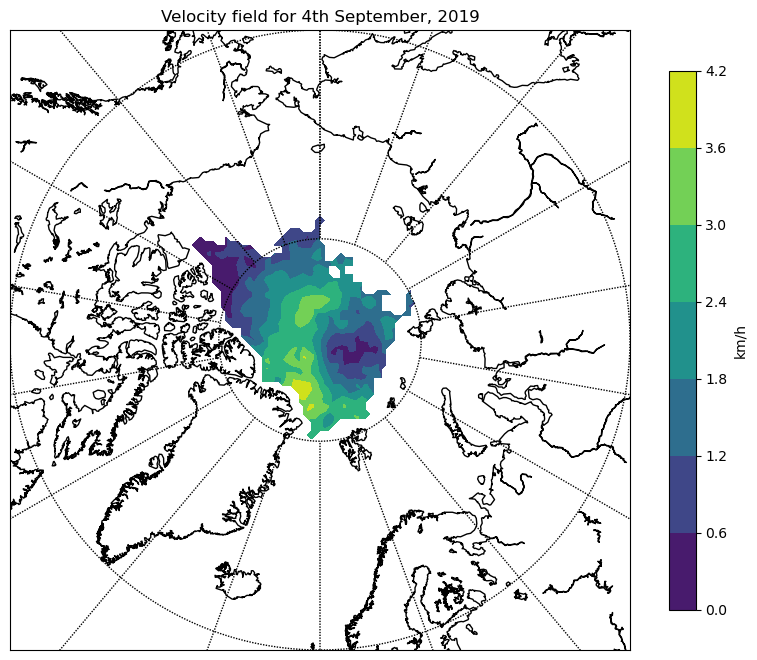

In [41]:
# don't plot if the spacing is lower than 50 (takes a while)
if SPACING >= 50:
    fig = plt.figure(figsize=(10,10))
    plt.set_cmap('viridis')
    m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l') # -180..180
    #m = Basemap(projection='npstere',boundinglat=75,lon_0=0,resolution='l') # -180..180
    #m = Basemap(projection='robin',boundinglat=40,lon_0=0,resolution='l')

    m.drawcoastlines()
    #m.fillcontinents(color='0.1',lake_color='lightblue')

    # draw parallels and meridians.
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))
    #m.drawmapboundary(fill_color='lightblue')

    lon_map,lat_map=m(lon_start[:,:],lat_start[:,:])
    m.contourf(lon_map, lat_map, plotfield)
    
    #plt.plot(lons[0][0], lats_df[0][0], 'ro')

    cbar=plt.colorbar(shrink=0.7)
    cbar.set_label('km/h')
    plt.title(f'Velocity field for 4th September, 2019')
    plt.show()


Check available years (2009 and 2024 are incomplete):

In [42]:
! ls /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/


2009  2011  2013  2015	2017  2019  2021  2023
2010  2012  2014  2016	2018  2020  2022  2024


### Configure points to be forwarded

In [43]:
# retrieve MISR data and coordinates
fn = f'/home/ssureen/MISR_data_monthly/April {YEAR} Roughness.h5'
sigma, sigma_lon, sigma_lat, sigma_x, sigma_y = load_MISR(fn)

# take an even subset of the data to reduce computational requirements
all_lats = sigma_lat[::SPACING, ::SPACING].ravel()
all_lons = sigma_lon[::SPACING, ::SPACING].ravel()
all_sigma = sigma[::SPACING, ::SPACING].ravel()

# remove NaNs
sigma_nan_indices = np.argwhere(np.isnan(all_sigma)).ravel()
sigma_cleaned = all_sigma[np.setdiff1d(range(len(all_sigma)), sigma_nan_indices).tolist()]
lats_cleaned = all_lats[np.setdiff1d(range(len(all_lats)), sigma_nan_indices).tolist()]
lons_cleaned = all_lons[np.setdiff1d(range(len(all_lons)), sigma_nan_indices).tolist()]

print(f'Sigma: {np.shape(all_sigma)}')
print(f'Lats: {np.shape(all_lats)}')
print(f'Lons: {np.shape(all_lons)}')

print(f'Number of NaNs: {np.shape(sigma_nan_indices)}')

print(f'Sigma cleaned: {np.shape(sigma_cleaned)}')
print(f'Lats cleaned: {np.shape(lats_cleaned)}')
print(f'Lons cleaned: {np.shape(lons_cleaned)}')

num_points = len(lons_cleaned)
delta_t = 86400

earliest_date = START_DATE
advect_start_date = START_DATE
dates = [advect_start_date]

lons = np.zeros((1, num_points))*np.nan
lats = np.zeros((1, num_points))*np.nan
lats_df = pd.DataFrame(data=lats, index=dates)
lons_df = pd.DataFrame(data=lons, index=dates)

lats_df.loc[advect_start_date] = lats_cleaned # np.arange(90.,110.,1.)
lons_df.loc[advect_start_date] = lons_cleaned # np.arange(90.,110.,1.)

points = Buoys(lons_df.loc[advect_start_date], lats_df.loc[advect_start_date], advect_start_date, earliest_date)


Sigma: (2916,)
Lats: (2916,)
Lons: (2916,)
Number of NaNs: (2517,)
Sigma cleaned: (399,)
Lats cleaned: (399,)
Lons cleaned: (399,)
0      -30.575277
1      -27.752947
2      -20.216473
3      -16.134451
4      -21.792940
          ...    
394   -173.810196
395   -177.523422
396    178.742462
397   -170.740646
398   -174.186417
Name: 2020-04-01 12:00:00, Length: 399, dtype: float64


### Forward points

Forward points one day at a time using daily sea ice advection data.

In [44]:
dists_travelled = np.zeros(num_points)
start_lats = lats_cleaned
start_lons = lons_cleaned
for i in np.arange(1, DAYS_TO_FORWARD+1):
    print('This is loop #'+str(i))

    Ufield, Vfield, lon_start, lat_start = loaddate_ofOSISAF(points.getdate(), hemisphere='nh')
    U,V = find_UV_atbuoy_pos(lon_start, lat_start, Ufield.flatten(),Vfield.flatten(), points)

    # don't advect buoys when there is no ice
    fixed=np.logical_or(U.mask, V.mask)
    U[fixed]=0.
    V[fixed]=0.

    LON,LAT = points.trajectory(U, V, delta_t=delta_t) # U,V in m/s, delta_t in seconds

    dists = np.zeros(num_points)
    end_lats = np.asarray(LAT)
    end_lons = np.asarray(LON)
    for i in range(num_points):
        dists[i] = geodesic((start_lats[i], start_lons[i]), (end_lats[i], end_lons[i])).km
    dists_travelled += dists
    start_lats = end_lats
    start_lons = end_lons
    # create dataframe with new lats and lons
    new_lons = pd.DataFrame(LON.rename(points.getdate())).T
    new_lats = pd.DataFrame(LAT.rename(points.getdate())).T

    # add dataframe with new lats and lons to original one
    lons_df = pd.concat([lons_df, new_lons])
    lats_df = pd.concat([lats_df, new_lats])

displacements = np.zeros(num_points)
for i in range(num_points):
    displacements[i] = geodesic((lats_cleaned[i], lons_cleaned[i]), (end_lats[i], end_lons[i])).km

#lons_df.to_pickle(f'/home/htweedie/melt_ponds/data/forwarded_coords/{YEAR}_lons_forwarded_{DAYS_TO_FORWARD}_days_spacing_{SPACING}.pkl')
#lats_df.to_pickle(f'/home/htweedie/melt_ponds/data/forwarded_coords/{YEAR}_lats_forwarded_{DAYS_TO_FORWARD}_days_spacing_{SPACING}.pkl')


This is loop #1
loading /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2020/04/ice_drift_nh_polstere-625_multi-oi_202004011200-202004031200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #2
loading /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2020/04/ice_drift_nh_polstere-625_multi-oi_202004021200-202004041200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #3
loading /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2020/04/ice_drift_nh_polstere-625_multi-oi_202004031200-202004051200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #4
loading /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/2020/04/ice_drift_nh_polstere-625_multi-oi_202004041200-202004061200.nc ...
Update buoy positions. Integrate for 24.0 hours.
This is loop #5
loading /home/htweedie/melt_ponds/data/drift-velocities/archive/ice/drift_lr/merged/

In [45]:
lats_df

,0,1,2,3,4,5,6,7,8,9,...,389,390,391,392,393,394,395,396,397,398
2020-04-01 12:00:00,66.9608,70.684578,71.794739,72.219536,73.064629,73.521004,73.876122,66.548126,74.81015,75.195290,...,70.562637,70.389389,70.124649,69.771866,68.968231,69.159134,69.262474,69.277023,67.617905,67.797775
2020-04-02 12:00:00,66.9608,70.684578,71.694038,72.219536,73.064629,73.399664,73.777258,66.548126,74.81015,75.131603,...,70.562637,70.389389,70.095184,69.771866,69.039389,69.210085,69.262474,69.277023,67.684238,67.797775
2020-04-03 12:00:00,66.9608,70.684578,71.593338,72.219536,73.064629,73.221249,73.626213,66.548126,74.81015,75.008936,...,70.562637,70.389389,70.022577,69.771866,69.113503,69.208239,69.262474,69.277023,67.759029,67.797775
2020-04-04 12:00:00,66.9608,70.684578,71.593338,72.219536,73.064629,73.058016,73.574032,66.548126,74.81015,74.859062,...,70.562637,70.389389,69.979435,69.771866,69.099081,69.046804,69.262474,69.277023,67.710827,67.797775
2020-04-05 12:00:00,66.9608,70.684578,71.593338,72.219536,73.064629,72.870966,73.528835,66.548126,74.81015,74.707554,...,70.562637,70.389389,69.979435,69.771866,68.987951,68.854286,69.262474,69.277023,67.497915,67.797775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-28 12:00:00,66.9608,70.684578,71.593338,71.035133,73.064629,71.552624,70.871528,66.548126,74.81015,71.689441,...,70.562637,70.389389,69.979435,69.771866,69.884995,69.342030,69.262474,69.277023,67.550674,67.797775
2020-08-29 12:00:00,66.9608,70.684578,71.593338,71.035133,73.064629,71.552624,70.871528,66.548126,74.81015,71.689441,...,70.562637,70.389389,69.979435,69.771866,69.884995,69.342030,69.262474,69.277023,67.550674,67.797775
2020-08-30 12:00:00,66.9608,70.684578,71.593338,71.035133,73.064629,71.552624,70.871528,66.548126,74.81015,71.689441,...,70.562637,70.389389,69.979435,69.771866,69.884995,69.342030,69.262474,69.277023,67.550674,67.797775
2020-08-31 12:00:00,66.9608,70.684578,71.593338,71.035133,73.064629,71.552624,70.871528,66.548126,74.81015,71.689441,...,70.562637,70.389389,69.979435,69.771866,69.884995,69.342030,69.262474,69.277023,67.550674,67.797775


In [46]:
lons_df

,0,1,2,3,4,5,6,7,8,9,...,389,390,391,392,393,394,395,396,397,398
2020-04-01 12:00:00,-30.575277,-27.752947,-20.216473,-16.134451,-21.79294,-17.436968,-12.862996,-52.030304,-18.959896,-14.023600,...,174.673477,170.743027,166.898407,163.170074,-170.148376,-173.810196,-177.523422,178.742462,-170.740646,-174.186417
2020-04-02 12:00:00,329.424723,332.247053,339.667090,343.865549,338.20706,342.407881,346.978920,307.969696,341.040104,345.844346,...,174.673477,170.743027,166.901446,163.170074,189.836216,186.206194,182.476578,178.742462,189.237588,185.813583
2020-04-03 12:00:00,329.424723,332.247053,339.551271,343.865549,338.20706,342.115535,346.680909,307.969696,341.040104,345.491727,...,174.673477,170.743027,166.982921,163.170074,189.784007,186.341511,182.476578,178.742462,189.208289,185.813583
2020-04-04 12:00:00,329.424723,332.247053,339.551271,343.865549,338.20706,341.733240,346.541309,307.969696,341.040104,345.015146,...,174.673477,170.743027,167.061088,163.170074,189.668409,186.545787,182.476578,178.742462,189.192929,185.813583
2020-04-05 12:00:00,329.424723,332.247053,339.551271,343.865549,338.20706,341.381269,346.327853,307.969696,341.040104,344.610032,...,174.673477,170.743027,167.061088,163.170074,189.598608,186.671386,182.476578,178.742462,189.266745,185.813583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-28 12:00:00,329.424723,332.247053,339.551271,341.311885,338.20706,339.606456,341.407343,307.969696,341.040104,339.735829,...,174.673477,170.743027,167.061088,163.170074,182.520680,182.595996,182.476578,178.742462,188.016916,185.813583
2020-08-29 12:00:00,329.424723,332.247053,339.551271,341.311885,338.20706,339.606456,341.407343,307.969696,341.040104,339.735829,...,174.673477,170.743027,167.061088,163.170074,182.520680,182.595996,182.476578,178.742462,188.016916,185.813583
2020-08-30 12:00:00,329.424723,332.247053,339.551271,341.311885,338.20706,339.606456,341.407343,307.969696,341.040104,339.735829,...,174.673477,170.743027,167.061088,163.170074,182.520680,182.595996,182.476578,178.742462,188.016916,185.813583
2020-08-31 12:00:00,329.424723,332.247053,339.551271,341.311885,338.20706,339.606456,341.407343,307.969696,341.040104,339.735829,...,174.673477,170.743027,167.061088,163.170074,182.520680,182.595996,182.476578,178.742462,188.016916,185.813583


### Plot trajectories

Plot starting locations and full trajectories.  
For displacement between start and end locations, use `displacements`. For totol distance travelled, use `dists_travelled`.  
For heatmap, comment out section for plotting trajectories and change marker type to 'o'.

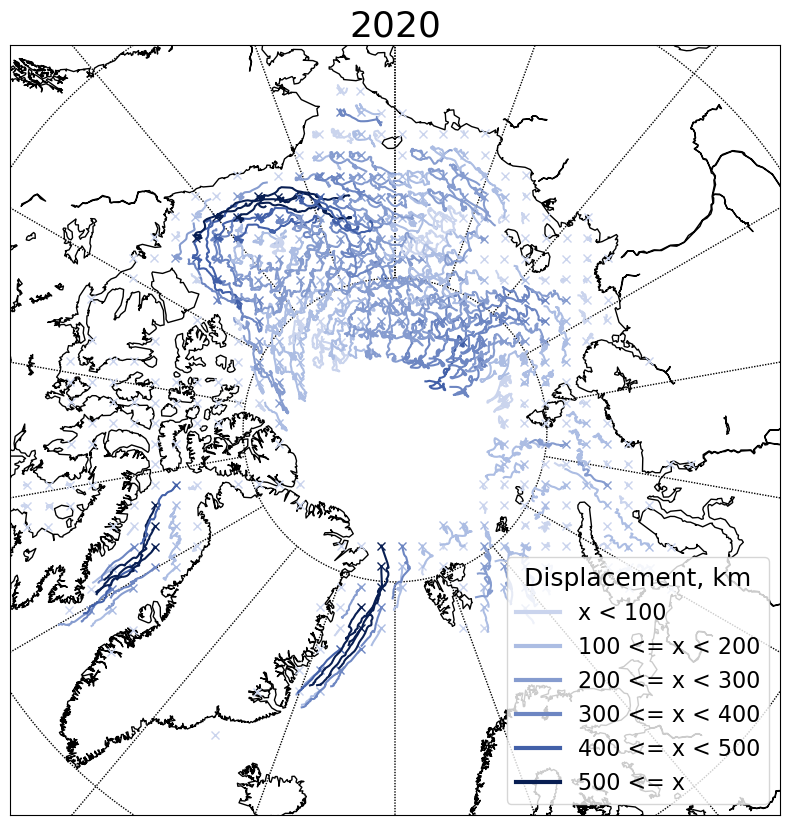

In [49]:
# don't plot if the spacing is lower than 50 (takes too long to plot)
if SPACING >= 50:
    fig = plt.figure(figsize=(10,10))

    m = Basemap(projection='npstere',boundinglat=65,lon_0=0,resolution='l')
    m.drawcoastlines()
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))

    lon_map,lat_map = m(lon_start[:,:],lat_start[:,:])

    for point_num in np.arange(0, num_points):
        # set colour of point based on the distance travelled
        if displacements[point_num] < 100:
            col = '#cad4ed'
        elif displacements[point_num] >= 100 and displacements[point_num] < 200:
            col = '#acbde3'
        elif displacements[point_num] >= 200 and displacements[point_num] < 300:
            col = '#869ccf'
        elif displacements[point_num] >= 300 and displacements[point_num] < 400:
            col = '#6d86c2'
        elif displacements[point_num] >= 400 and displacements[point_num] < 500:
            col = '#4260a8'
        else:
            col = '#081e52'
    
        # comment out this section for heatmap
        a = np.ma.array(lons_df[point_num][:].values, mask=np.isnan(lons_df[point_num][:].values))
        b = np.ma.array(lats_df[point_num][:].values, mask=np.isnan(lats_df[point_num][:].values))
        lon_traj,lat_traj = m(a,b)
        m.plot(lon_traj, lat_traj, color=col)
        
        a = np.ma.array(lons_df[point_num][0:1].values, mask=np.isnan(lons_df[point_num][0:1].values))
        b = np.ma.array(lats_df[point_num][0:1].values, mask=np.isnan(lats_df[point_num][0:1].values))
        lon_traj,lat_traj=m(a,b)
        m.plot(lon_traj, lat_traj, marker='x', color=col) # change this marker type to 'o' for heatmap

    # format legend
    colors = ['#cad4ed', '#acbde3', '#869ccf', '#6d86c2', '#4260a8', '#081e52']
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
    labels = ['x < 100', '100 <= x < 200', '200 <= x < 300', '300 <= x < 400', '400 <= x < 500', '500 <= x']
    plt.legend(lines, labels, loc = 'lower right', title='Displacement, km', fontsize=16, title_fontsize=18)

    plt.title(f'{YEAR}', fontsize=26)
    plt.show()
